# Aula 6 - DBSCAN

Agora que já começamos a nos familiarizar com a aprendizagem não supervisionada e com o K-Means, na aula de hoje, vamos avaliar um novo método para clusterização: o **DBSCAN**.

<img src = "https://scikit-learn.org/stable/_images/sphx_glr_plot_cluster_comparison_001.png">

https://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_comparison.html

____
____
_____

## DBSCAN

Veja, abaixo, uma figura com um exemplo ilustrativo da diferença de clusterização entre o K-Means e o DSBCAN. Você consegue imaginar motivos pelos quais surgem essas diferenças nos grupos de pontos no espaço de atributos?

<img src = "https://miro.medium.com/v2/resize:fit:4800/format:webp/1*rfi9uHjGPdNgXgxe9xWvVw.png">

## DBSCAN

O DBSCAN é um algoritmo de clusterização baseado no conceito de **densidade**.

O nome do algoritmo é uma sigla, que explica bem seu funcionamento: **D**ensity-**B**ased **S**patial **C**lustering of **A**pplications with **N**oise.

O algoritmo foi proposto com o objetivo de proporcionar uma técnica de clusterização que possa funcionar **mesmo quando os clusters a serem criados não forem uniformes**, tendo **tamanho, forma e densidade variáveis**. 

Além disso, por construção o método funciona bem em contextos em que há **ruídos/outliers**, sendo capaz de detectá-los sem influenciar a criação dos clusters. 

Por fim, uma vantagem enorme é o fato do algoritmo **não demandar a determinação prévia da quantidade de clusters**, o que é uma vantagem interessante se não houver indicações do problema de negócio para esta determinação (embora, como veremos, ainda há hiperparâmetros importantes a serem determinados).

Vamos entender o funcionamento do algoritmo mais a fundo!

<div class="warning" style='padding:0.1em; background-color:#E9D8FD; color:#69337A'>
<span>
<h2>Princípio de funcionamento</h2>
<ul>
<li>O DBSCAN tem como princípio fundamental a <b>determinação de regiões de alta densidade de observações</b>, que são <b>separadas entre si por regiões de baixa densidade</b>.
</ul>
</span>
<br>
</div>

Lembrando que, por ser um algoritmo não-supervisionado de clusterização, quando nos referimos a "regiões" cuja densidade será aferida, estamos nos referindo a regiões **do espaço de features**.

Uma pergunta natural é: **como determinar a densidade de uma região?** Para responder a esta pergunta, precisamos de algumas definições:

> **Densidade em um ponto $P$:** número de pontos dentro de um círculo de raio $\epsilon$ centrado no ponto $P$ (região chamada de vizinhança-$\epsilon$ de $P$);

> **Região densa**: dizemos que uma região é densa se o círculo de raio $\epsilon$ contém pelo menos um número mínimo de pontos (que chamaremos de $\text{minPts}$. Uma região densa **formará um cluster**.

Para visualizar as definições acima, considere a figura a seguir:

<img src=https://www.researchgate.net/publication/315326812/figure/fig2/AS:473095908663297@1489806262333/A-cluster-consists-of-core-points-red-and-border-points-green-Core-points-have-at.png width=500>

<img src=https://www.researchgate.net/publication/335485895/figure/fig2/AS:797412515909651@1567129367940/A-single-DBSCAN-cluster-with-Core-Border-and-Noise-Points.ppm width=500>

Dada a definição acima, podemos classificar pontos dentro de um cluster como:

> **Core points (pontos centrais)**: são pontos que estão no interior dos clusters (regiões densas). Matematicamente, um ponto é considerado core **se sua densidade é de pelo menos $\text{minPts}$**, ou seja, se **há pelo menos $\text{minPts}$ pontos dentro do círculo de raio $\epsilon$ centrado no ponto**.

> **Border points (pontos de fronteira)**: são pontos que estão na fronteira de um cluster. Matematicamente, estes pontos **têm densidade menor que $\text{minPts}$**, mas que **fazem parte da vizinhança-$\epsilon$ de um ponto central**.

> **Noisy points (pontos de ruído/outliers)**: são pontos que não são centrais nem de fronteira. Estes pontos não fazem parte do cluster, e são considerados outliers.


Olhando para as definições acima, e pras figuras, fica claro que $\epsilon$ e $\text{minPts}$ são os hiperparâmetros do modelo -- e que os clusters gerados são fortemente dependentes destes hiperparâmetros!


> - $\epsilon$ (`eps` no sklearn): determina o quão próximos (relativo a uma dada **métrica de distância**) os pontos devem estar entre si para serem considerados vizinhos, e, eventualmente, parte de um cluster. Na prática, **se a distância entre dois pontos for menor ou igual a $\epsilon$, os pontos serão considerados vizinhos**;
<br><br>
>Se o valor de `eps` for muito pequeno, grande parte dos dados não serão clusterizados - muitos pontos serão considerados outliers, pois não haverá vizinhos suficientes para gerar uma região densa;<br><br>
>Por outro lado, se o valor de `eps` for muito grande, os clusters se fundirão, e a maioria dos pontos estarão em um único, grande cluster.<br><br>
>Portanto, a escolha de `eps` está muito relacionada com **a escala** das features, o que demanda cuidadosa análise exploratória.<br><br>
>Além disso, note que o  `eps` depende também fortemente da **métrica de distância** (`metric` no sklearn) a ser utilizada.


> - $\text{minPts}$ (`min_samples` no sklearn): o número mínimo de pontos que devem ser vizinhos para formar uma região densa, que será um cluster.
<br><br>
Valores maiores de `min_samples` são preferíveis para datasets com outliers, formando clusters mais significativos (isto é, um cluster só será formado se realmente tiver uma alta densidade).

Para algumas dicas práticas de como estimar bons valores para os hiper-parâmetros, [clique aqui](https://en.wikipedia.org/wiki/DBSCAN#Parameter_estimation).



-----
**Leitura complementar**

[Understanding DBSCAN and implementation with python](https://towardsdatascience.com/understanding-dbscan-and-implementation-with-python-5de75a786f9f)

__________

Agora que entendemos os princípios e principais hiperparâmetros do DBSCAN, vamos agora nos atentar um pouco melhor aos passos de execução do algoritmo.

> **Passo 1**: o algoritmo escolhe aleatoriamente um dos pontos, e sua vizinhança-$\epsilon$ é calculada;

> **Passo 2**: se este ponto tem $\text{minPts}$ em sua vizinhança-$\epsilon$, a formação do cluster é iniciada (veja próximo passo). Se não, o ponto é marcado como outlier (mas pode ser considerado como border point de um outro cluster posteriormente). Se for um outlier, volte ao passo 1;

> **Passo 3**: se o ponto for um core point, todos os pontos na vizinhança são agregados ao cluster, e o passo 1 é aplicado a cada um deles;

> **Passo 4**: o processo do passo 3 é continuado até que todos os pontos tenham um cluster associado ou esteja marcado como noise.

Podemos visualizar a seguir o DBSCAN em funcionamento:


<img src="http://data-analysis-stats.jp/wp-content/uploads/2019/09/DBSCAN_01.gif" width=400>


<img src=https://i.pinimg.com/originals/bb/3d/5e/bb3d5e522cbcb2dd07a81f8118de2041.gif width=500>


A classe do sklearn é esta: [DBSCAN](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html)


Agora, vamos avaliar duas situações, possibilitando comparações com o K-means:
- a aplicação do DBSCAN em um dataset artificial, como fizemos na aula passada;
- uma aplicação para clusterização de estações de metrô em São Paulo.

____


### DBSCAN na prática: dataset artificial

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import make_blobs

Geração de dados (como fizemos na última aula)

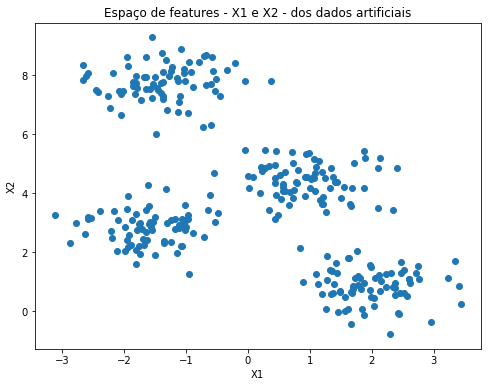

In [3]:
X, _ = make_blobs(n_samples = 300,
                 n_features = 2,
                 centers = 4,
                 cluster_std = 0.6,
                 random_state = 0)

plt.figure(figsize = (8,6))
plt.scatter(X[:,0], X[:,1])
plt.xlabel("X1")
plt.ylabel("X2")

plt.title("Espaço de features - X1 e X2 - dos dados artificiais")
plt.show()

Agora, vamos utilizar o [DBSCAN](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html) nos nossos dados para encontrar clusters.

In [4]:
from sklearn.cluster import DBSCAN

In [7]:
X_df = pd.DataFrame(X, columns = ["X1", "X2"])
X_df.head()

,X1,X2
0,0.836857,2.136359
1,-1.413658,7.409623
2,1.155213,5.099619
3,-1.018616,7.814915
4,1.271351,1.892542


In [8]:
dbscan = DBSCAN()

In [9]:
dbscan.fit(X_df[["X1","X2"]])

DBSCAN()

In [10]:
dbscan.labels_

array([ 2,  0,  1,  0,  2, -1,  3,  1,  0,  0,  3,  0,  1,  0,  2,  1,  1,
        2,  3,  3,  2,  2,  1,  3,  3, -1,  2,  1,  3,  1,  0,  0,  1,  0,
        0,  0,  0,  0,  3,  2,  1,  3, -1,  1,  3,  3,  0,  3,  0,  2,  3,
        2,  0,  2,  2,  3,  0,  3,  0,  2,  0,  1, -1,  3,  3,  3,  0,  2,
        0,  3,  1,  3,  0,  3,  3,  0,  3,  1,  2,  0,  2,  1,  2,  2,  0,
        1,  2,  1, -1,  0,  1,  2,  0,  3,  3,  1,  2,  2,  1,  3,  0,  2,
        0,  2,  1,  2,  2,  1,  0,  1,  3,  3,  2,  0,  2,  1,  0,  2,  2,
        1,  3,  2,  3,  2,  2,  2,  2,  3,  2,  3,  0,  3,  3,  2,  0,  3,
        3,  0,  1,  0,  0,  3,  1, -1,  1,  3,  0,  1,  0,  0,  0,  1, -1,
        1,  2,  3,  0,  3,  2,  1,  0,  1,  1,  2,  1,  3, -1,  1,  2,  1,
        1,  0,  2,  1, -1,  0,  2,  2,  1,  3,  2,  1,  3,  3,  1,  1,  1,
        1,  2,  0,  1,  3,  1,  1,  3,  3,  3,  1,  3,  0,  1,  3,  2,  3,
        1, -1,  3,  0,  1,  0,  1,  3,  1,  1,  0,  3,  3,  2, -1,  1,  0,
        2,  2,  3,  2,  3

In [11]:
X_df["labels"] = dbscan.labels_

In [12]:
X_df.head()

,X1,X2,labels
0,0.836857,2.136359,2
1,-1.413658,7.409623,0
2,1.155213,5.099619,1
3,-1.018616,7.814915,0
4,1.271351,1.892542,2


<AxesSubplot:xlabel='X1', ylabel='X2'>

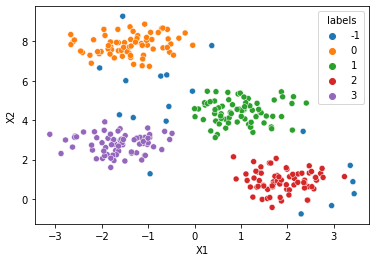

In [14]:
sns.scatterplot(data = X_df, x = "X1", y = "X2", hue = "labels", palette = "tab10")

**Observação:** com o DBSCAN, dados considerados outliers/ruído (*noisy data*) são, por padrão, rotulados com $-1$.

Similarmente como fizemos para o K-means na última aula, vamos, agora, definir uma função para visualizar nossos agrupamentos para uma entrada específica dos parâmetros *eps* e *min_pts*.

In [18]:
def plot_dbscan(X_df, eps, min_pts):
     # Instanciamento e fit do modelo
    dbscan = DBSCAN(eps = eps, min_samples = min_pts)
    dbscan.fit(X_df)

    # ========================================
    # estruturação dos resultados
    labels_clusters = dbscan.labels_
    labels_series = pd.Series(labels_clusters, name="label")

    df_result = pd.concat([X_df, labels_series], axis=1)
    n_clusters = pd.Series(labels_clusters).nunique()

    # ========================================
    print(f"DBSCAN com eps={eps} e minPts={min_pts}\nNúmero de clusters: {n_clusters}")
    sns.jointplot(data=df_result, x="X1", y="X2", hue="label", palette="viridis")
    plt.show()
    
    print("Quantidade de pontos em cada clusters:")
    print(pd.Series(labels_clusters).value_counts())
    
    return df_result, n_clusters

Vamos avaliar nossa função para os valores-padrão dos parâmetros do scikit-learn?

DBSCAN com eps=0.5 e minPts=5
Número de clusters: 5


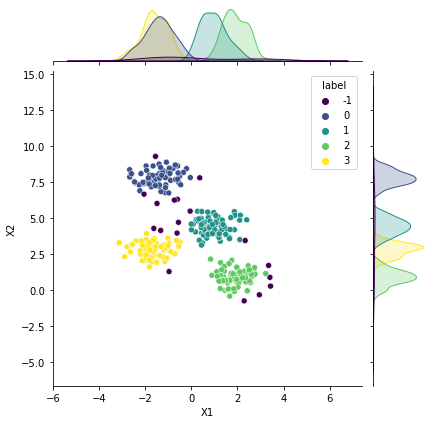

Quantidade de pontos em cada clusters:
 1    72
 3    71
 2    70
 0    69
-1    18
dtype: int64


In [19]:
df_result, n_clusters = plot_dbscan(X_df,
                                   eps = 0.5,
                                   min_pts = 5)

Podemos observar que, para os valores-padrão dos parâmetros de entrada, obtemos apenas um grande cluster de dados - o que não nos auxilia. Sendo assim, o que acontece quando variamos os parâmetros?

DBSCAN com eps=0.2 e minPts=5
Número de clusters: 10


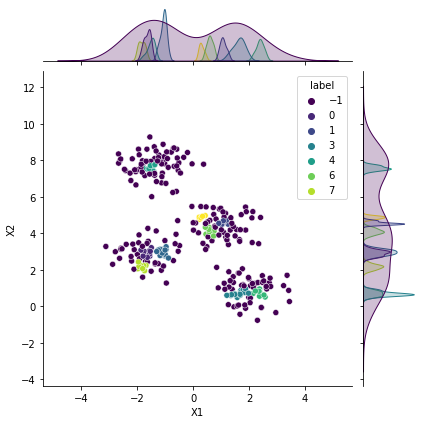

Quantidade de pontos em cada clusters:
-1    209
 2     16
 3     15
 0     12
 4      9
 6      9
 5      9
 1      8
 7      8
 8      5
dtype: int64


In [21]:
df0, _ = plot_dbscan(X_df, eps = 0.2, min_pts = 5)

Conforme esperaríamos, à medida que aumentamos $\epsilon$, conseguimos detectar menos agrupamentos com o DBSCAN (já que é necessária uma distância cada vez menor entre os pontos).

DBSCAN com eps=0.1 e minPts=5
Número de clusters: 2


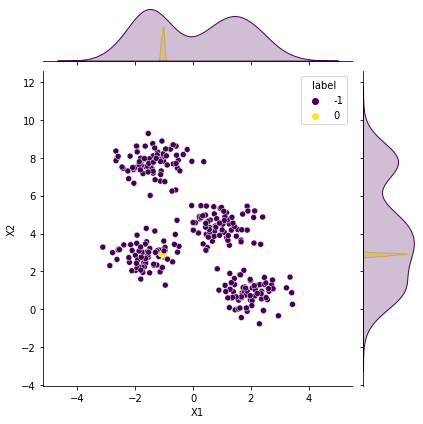

Quantidade de pontos em cada clusters:
-1    294
 0      6
dtype: int64
DBSCAN com eps=0.2 e minPts=5
Número de clusters: 10


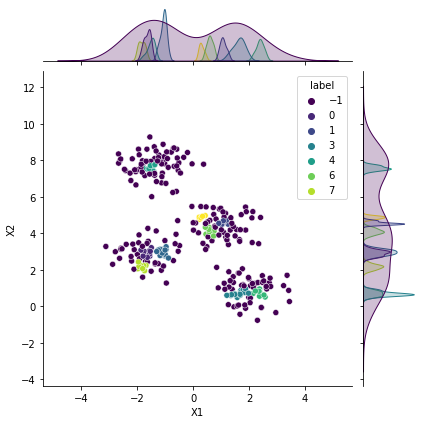

Quantidade de pontos em cada clusters:
-1    209
 2     16
 3     15
 0     12
 4      9
 6      9
 5      9
 1      8
 7      8
 8      5
dtype: int64
DBSCAN com eps=0.30000000000000004 e minPts=5
Número de clusters: 12


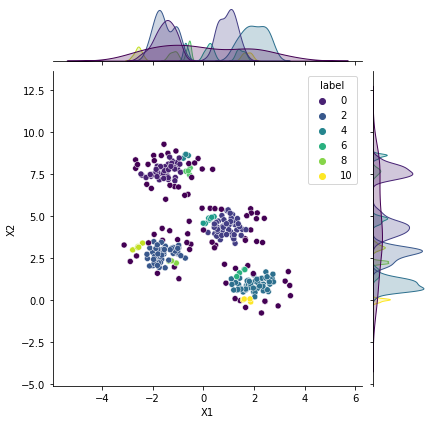

Quantidade de pontos em cada clusters:
-1     77
 2     50
 3     50
 1     48
 0     42
 5      7
 6      5
 9      5
 4      4
 8      4
 7      4
 10     4
dtype: int64
DBSCAN com eps=0.4 e minPts=5
Número de clusters: 6


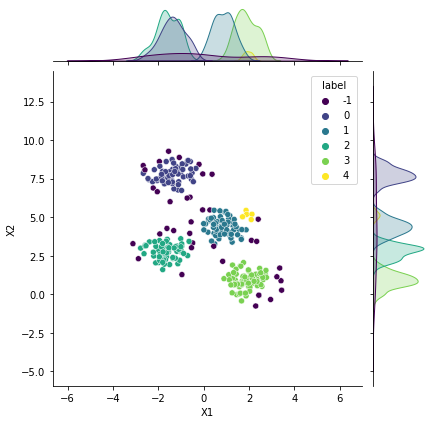

Quantidade de pontos em cada clusters:
 3    66
 2    66
 1    63
 0    61
-1    39
 4     5
dtype: int64
DBSCAN com eps=0.5 e minPts=5
Número de clusters: 5


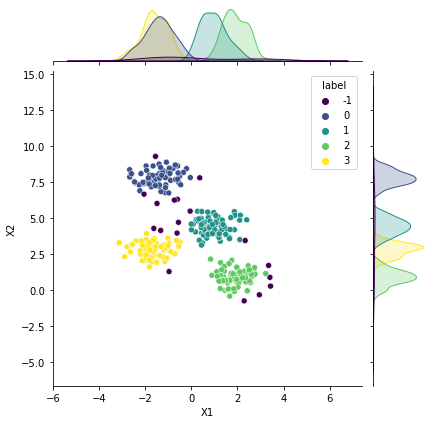

Quantidade de pontos em cada clusters:
 1    72
 3    71
 2    70
 0    69
-1    18
dtype: int64
DBSCAN com eps=0.6 e minPts=5
Número de clusters: 5


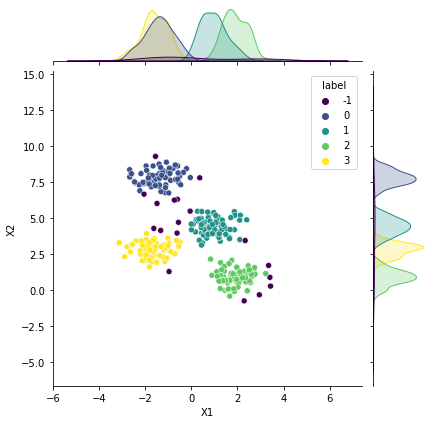

Quantidade de pontos em cada clusters:
 1    72
 3    71
 2    70
 0    69
-1    18
dtype: int64
DBSCAN com eps=0.7000000000000001 e minPts=5
Número de clusters: 5


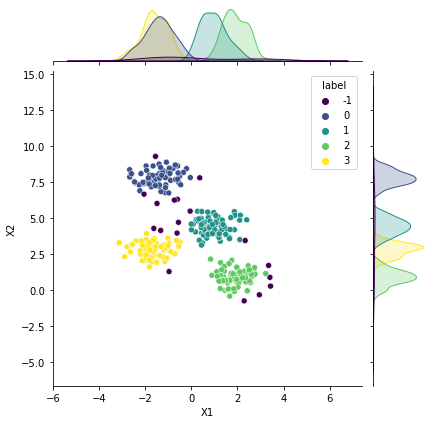

Quantidade de pontos em cada clusters:
 1    72
 3    71
 2    70
 0    69
-1    18
dtype: int64
DBSCAN com eps=0.8 e minPts=5
Número de clusters: 5


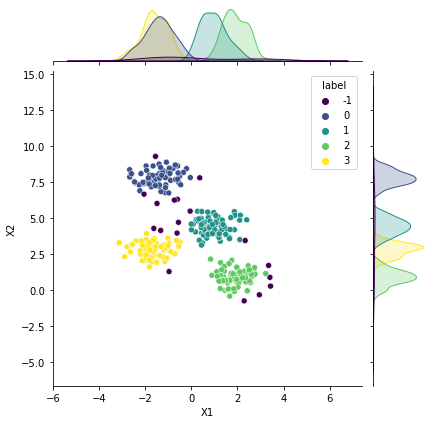

Quantidade de pontos em cada clusters:
 1    72
 3    71
 2    70
 0    69
-1    18
dtype: int64
DBSCAN com eps=0.9 e minPts=5
Número de clusters: 5


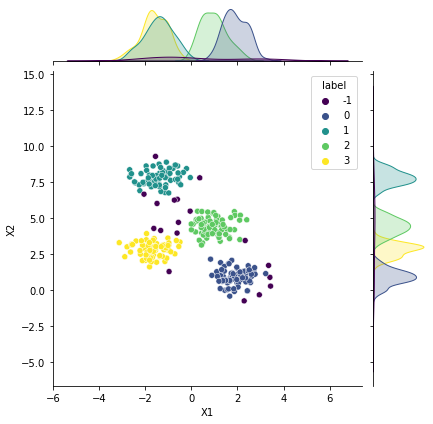

Quantidade de pontos em cada clusters:
 2    72
 3    71
 0    70
 1    69
-1    18
dtype: int64
DBSCAN com eps=1.0 e minPts=5
Número de clusters: 5


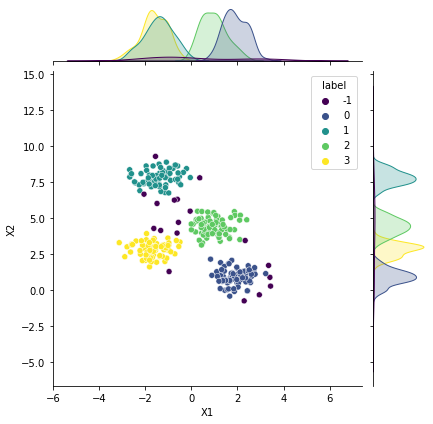

Quantidade de pontos em cada clusters:
 2    72
 3    71
 0    70
 1    69
-1    18
dtype: int64


In [23]:
# variando o eps
eps_values = np.linspace(0.1,1.0, 10)
n_clusters = []

for eps in eps_values:
    _, n = plot_dbscan(X_df, eps = eps, min_pts = 5)
    n_clusters.append(n)

In [33]:
from sklearn.metrics import silhouette_score

N_CLUSTERS = 2


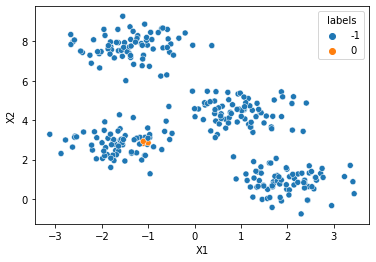


###

N_CLUSTERS = 10


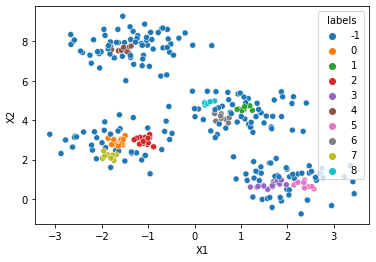


###

N_CLUSTERS = 12


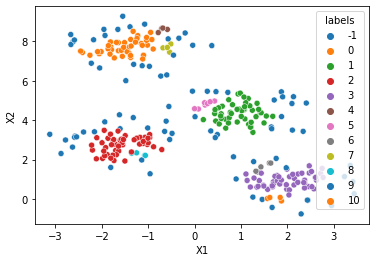


###

N_CLUSTERS = 6


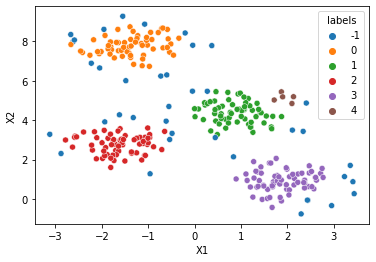


###

N_CLUSTERS = 5


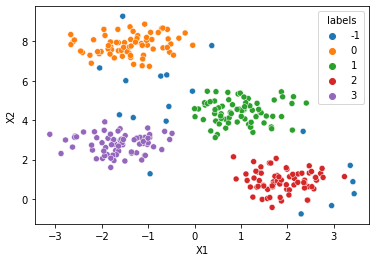


###



Text(0.5, 1.0, 'Gráfico da silhueta')

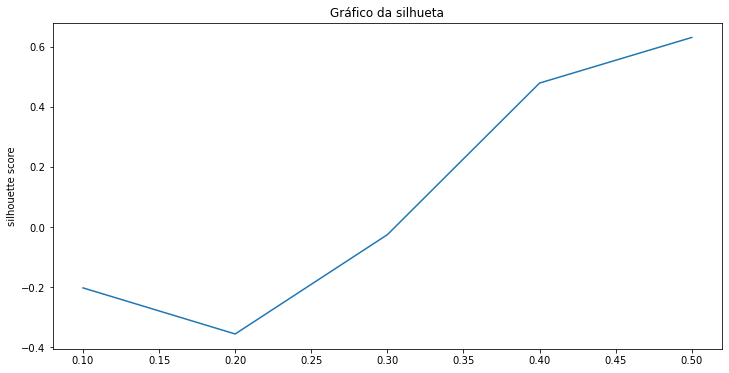

In [39]:
X_df_3 = X_df[["X1", "X2"]]

silhuetas = []
for e in np.linspace(0.1,0.5, 5):
    dbscan = DBSCAN(eps = e, min_samples = 5)
    dbscan.fit(X_df_3[["X1","X2"]])
    labels = dbscan.labels_
    X_df_3["labels"] = labels
    k = X_df_3["labels"].nunique()
    
    print(f"N_CLUSTERS = {k}")
    sns.scatterplot(data = X_df_3, x = "X1", y = "X2", hue = "labels", palette = "tab10")
    plt.show()

    silhueta = silhouette_score(X_df_3[["X1","X2"]], labels)
    silhuetas.append(silhueta)
    print("\n###\n")
    
fig, ax = plt.subplots(1,1,figsize = (12,6))
ax.plot(np.linspace(0.1,0.5, 5), silhuetas)
ax.set_ylabel("silhouette score")
ax.set_title("Gráfico da silhueta")

___

In [24]:
from sklearn.datasets import load_wine 

data = load_wine()

In [25]:
data.keys()

dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names'])

In [26]:
data["data"].shape

(178, 13)

In [27]:
import pandas as pd 
df = pd.DataFrame(data = data["data"], columns = data["feature_names"])
df["class"] = data["target"]

In [28]:
df

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,class
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,13.71,5.65,2.45,20.5,95.0,1.68,0.61,0.52,1.06,7.70,0.64,1.74,740.0,2
174,13.40,3.91,2.48,23.0,102.0,1.80,0.75,0.43,1.41,7.30,0.70,1.56,750.0,2
175,13.27,4.28,2.26,20.0,120.0,1.59,0.69,0.43,1.35,10.20,0.59,1.56,835.0,2
176,13.17,2.59,2.37,20.0,120.0,1.65,0.68,0.53,1.46,9.30,0.60,1.62,840.0,2


In [21]:
# import seaborn as sns 

# sns.pairplot(df, hue = "class")